In [17]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import PIL
from functools import reduce

In [18]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
def path2img(path):
    img = PIL.Image.open(path)
    return img
def path2imgarray(path):
    import cv2
    img = PIL.Image.open(path).resize((IMG_WIDTH, IMG_HEIGHT))
    img = np.array(img)
    def binaryzation(img):
        cv_img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        return cv_img

    img = binaryzation(img) if len(img.shape) == 3 else img / 255.0
    img = img.reshape(IMG_HEIGHT, IMG_WIDTH, 1)
    return img



In [19]:
# 识别验证码模型
import functools
class CaptchaIdentifier(keras.Model):
    
    labelLen = 4
    
    charSet = [chr(ord('A') + i) for i in range(26)]
    charSetLen = len(charSet)
    def text2vector(self, text):
        vectors = np.zeros([self.labelLen, self.charSetLen], dtype=np.float32)
        for i, c in enumerate(text):
            vectors[i, self.charSet.index(c)] = 1.0
        return vectors
    def vector2text(self, vectors):
        return ''.join(map(lambda vector: chr(ord('A') + vector.index(np.max(vector))),vectors))
    def __init__(self):
        layers = keras.layers
        super().__init__()
        self.model = tf.keras.Sequential([
            layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1)), # (128, 128, 1)

            layers.Conv2D(16, (7,7), activation='relu'),    # (128, 128, 16)
            layers.MaxPooling2D((2, 2)),                    # (64, 64, 16)

            layers.Conv2D(128, (3, 3), activation='relu'),  # (64, 64, 128)
            layers.MaxPooling2D((2, 2),),                   # (32, 32, 128)
            
            layers.Flatten(),                             
            layers.Dense(1024, activation='relu', ),        # (1024)
            layers.Dropout(0.2),
            
            layers.Dense(CaptchaIdentifier.labelLen * CaptchaIdentifier.charSetLen), # (144)
            layers.Reshape([CaptchaIdentifier.labelLen, CaptchaIdentifier.charSetLen]), # 144 -> (4, 36)

            layers.Softmax()                              # (4, 36) -> (4, 36)
        ])
        
                
    def call(self, x):
        return self.model(x)


In [20]:
# Create an instance of the model
identifier = CaptchaIdentifier()

trainLoss = tf.keras.metrics.Mean(name='trainLoss')
valLoss = tf.keras.metrics.Mean(name='valLoss')
trainAccuracy = tf.keras.metrics.CategoricalAccuracy(name='trainAccuracy')
valAccuracy = tf.keras.metrics.CategoricalAccuracy(name='valAccuracy')
calLoss = tf.keras.losses.CategoricalCrossentropy()

identifier.build(input_shape=(None, IMG_HEIGHT, IMG_WIDTH, 1))
identifier.summary()
# 查看每一层
print('model')

for layer in identifier.model.layers:
    print(layer.name, layer.output_shape)

Model: "captcha_identifier_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 4, 26)             110358536 
                                                                 
Total params: 110,358,536
Trainable params: 110,358,536
Non-trainable params: 0
_________________________________________________________________
model
conv2d_4 (None, 122, 122, 16)
max_pooling2d_4 (None, 61, 61, 16)
conv2d_5 (None, 59, 59, 128)
max_pooling2d_5 (None, 29, 29, 128)
flatten_2 (None, 107648)
dense_4 (None, 1024)
dense_5 (None, 104)
reshape_2 (None, 4, 26)
softmax_2 (None, 4, 26)


In [21]:
def getTrainStap(model):
    optimizer = tf.keras.optimizers.Adam()
    @tf.function
    def trainStep(images, labels):
        with tf.GradientTape() as tape:
            predictions = model(images)
            # print(f'predict shape {predictions.shape}')
            loss = calLoss(labels, predictions)
            # print('calLoss end')
        gradients = tape.gradient(loss, model.trainable_variables)
        # print(1)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        # print(1)
        trainLoss(loss)
        trainAccuracy(labels, predictions)
        # print(1)
    return trainStep

def getcValStep(model):
    @tf.function
    def valStep(images, labels):
        predictions = model(images, training=False)
        loss = calLoss(labels, predictions)

        valLoss(loss)
        valAccuracy(labels, predictions)
    return valStep

In [22]:
import os
def basenameWithoutExt(path):
    return os.path.basename(path).split('.')[0]


# Data

In [23]:
BATCH_SIZE = 50

    
trainDir = './dataset1/train/'
testDir = './dataset1/test/'
# noise 和文件名是一一对应的
dataset = tf.data.Dataset.from_tensor_slices(
    ([path2imgarray(path) for path in tf.io.gfile.glob(trainDir + '*.jpg')], 
    [identifier.text2vector(basenameWithoutExt(path).replace('_resample', '')) for path in tf.io.gfile.glob(trainDir + '*.jpg')])
)
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

valDataset = tf.data.Dataset.from_tensor_slices(
    ([path2imgarray(path) for path in tf.io.gfile.glob(testDir + '*.jpg')],
    [identifier.text2vector(basenameWithoutExt(path).replace('_resample', '')) for path in tf.io.gfile.glob(testDir + '*.jpg')])
)

valDataset = valDataset.shuffle(buffer_size=1000)
valDataset = valDataset.batch(BATCH_SIZE)
valDataset = valDataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

print(len(dataset))

6


(50, 4, 26)
QHCM
(50, 128, 128, 1)


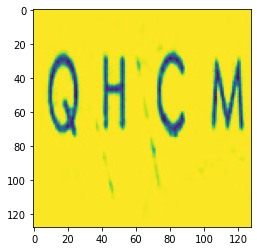

In [24]:
text = [*dataset.take(1)][0]
print(text[1].shape)
# print(text[1][0])
print(identifier.vector2text(np.array(text[1][0]).tolist()))

print(text[0].shape)
plt.imshow(text[0][0])

# print(text[0][0])
# identifier.text2vector(text.numpy().decode('utf-8'))

In [25]:
import time
# train face1
trainStep = getTrainStap(identifier)
valStep = getcValStep(identifier)
EPOCHS = 500

trainLossHistory = []
valLossHistory = []
trainAccHistory = []
valAccHistory = []
epochsRange = []



start = time.time()
for epoch in range(EPOCHS):
    trainLoss.reset_states()
    valLoss.reset_states()
    trainAccuracy.reset_states()
    valAccuracy.reset_states()
        
    for images, labels in dataset:
        trainStep(images, labels)
    
    # random validate
    for images, labels in valDataset.take(1):
        valStep(images, labels)

    
    print(
        f'Epoch {epoch + 1}, '
        f'\nTrain      Loss: {trainLoss.result()}, '
        f'Train      Acc: {trainAccuracy.result()} '
        f'\nValidation Loss: {valLoss.result()}'
        f'Validation  Acc: {valAccuracy.result()}'
        f' - {int((time.time() - start) / (epoch + 1) * (EPOCHS - epoch)) / 60} minutes left,\n '
    )
    trainLossHistory.append(trainLoss.result())
    valLossHistory.append(valLoss.result())
    trainAccHistory.append(trainAccuracy.result())
    valAccHistory.append(valAccuracy.result())
    epochsRange.append(epoch)



Epoch 1, 
Train      Loss: 6.054677486419678, Train      Acc: 0.036666665226221085 
Validation Loss: 3.386936902999878Validation  Acc: 0.029999999329447746 - 25.65 minutes left,
 
Epoch 2, 
Train      Loss: 3.3143041133880615, Train      Acc: 0.03750000149011612 
Validation Loss: 3.297605037689209Validation  Acc: 0.029999999329447746 - 24.033333333333335 minutes left,
 
Epoch 3, 
Train      Loss: 3.254223585128784, Train      Acc: 0.05999999865889549 
Validation Loss: 3.2640128135681152Validation  Acc: 0.04500000178813934 - 24.366666666666667 minutes left,
 
Epoch 4, 
Train      Loss: 3.2278575897216797, Train      Acc: 0.07083333283662796 
Validation Loss: 3.25571870803833Validation  Acc: 0.03999999910593033 - 23.183333333333334 minutes left,
 
Epoch 5, 
Train      Loss: 3.195366859436035, Train      Acc: 0.09416666626930237 
Validation Loss: 3.2532565593719482Validation  Acc: 0.054999999701976776 - 22.166666666666668 minutes left,
 
Epoch 6, 
Train      Loss: 3.151024580001831, Train

KeyboardInterrupt: 

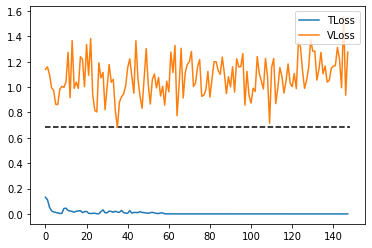

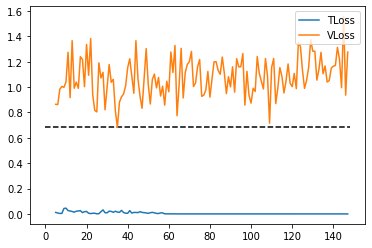

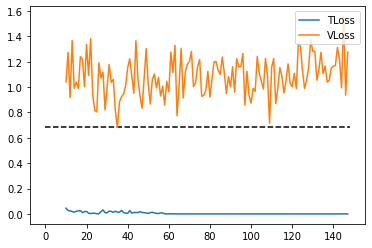

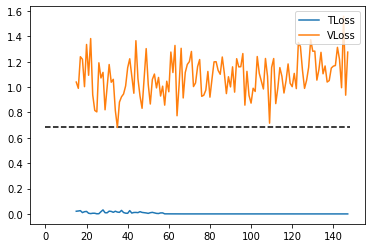

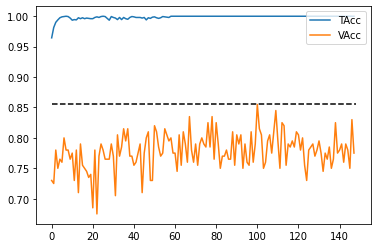

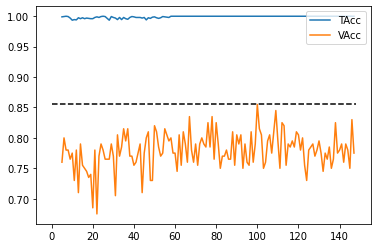

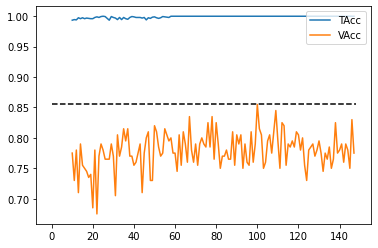

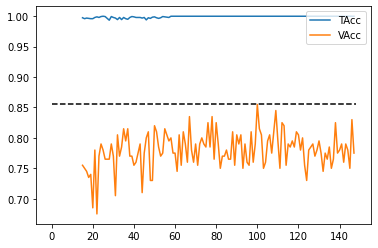

In [ ]:
minloss = np.min(valLossHistory)
maxacc = np.max(valAccHistory)
epochln = len(epochsRange)


for i in range(4):
  # dpi = 200
  # plt.figure(figsize=(20, 20), dpi=200)
  # 画虚线 y = minloss
  plt.plot([0, epochln], [minloss,minloss],linestyle='--',color='black')
  
  plt.plot(epochsRange[5 * i:], trainLossHistory[5 * i:], label='TLoss')
  plt.plot(epochsRange[5 * i:], valLossHistory[5 * i:], label='VLoss')
  # 图例
  plt.legend(loc='upper right')
  plt.show()

for i in range(4):
  # plt.figure(figsize=(20, 20), dpi=200)
  # 画虚线 y = maxacc
  plt.plot([0, epochln], [maxacc,maxacc],linestyle='--',color='black')
  plt.plot(epochsRange[5 * i:], trainAccHistory[5 * i:], label='TAcc')
  plt.plot(epochsRange[5 * i:], valAccHistory[5 * i:], label='VAcc')
  # 图例
  plt.legend(loc='upper right')
  plt.show()

IMIQ


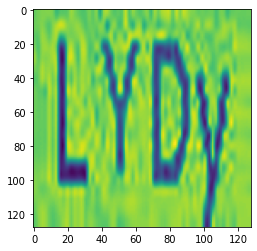

In [ ]:
img = path2imgarray('./test.jpeg')
img = img.reshape((1,IMG_HEIGHT,IMG_WIDTH,1))
plt.imshow(img[0])
print(identifier.vector2text(np.array(identifier(img,training=False)[0]).tolist()))

tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]], shape=(4, 26), dtype=float32)
SUSE
IMBQ


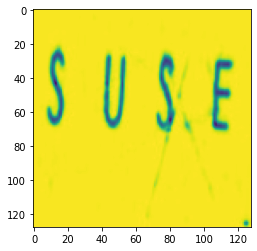

In [ ]:
text = [*valDataset.take(1)][0]
print(text[1][0])
print(identifier.vector2text(np.array(text[1][0]).tolist()))
print(identifier.vector2text(np.array(identifier(text[0][:1],training=False)[0]).tolist()))
change = tf.keras.Sequential([
              # keras.layers.RandomFlip("horizontal"),
            keras.layers.RandomRotation(0.01),
            keras.layers.RandomZoom(0.1),
])
plt.imshow(change(text[0][0]))
